<a href="https://colab.research.google.com/github/IvanKatorgin/Computer-vision/blob/main/%D0%9A%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D0%B7%D1%80%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Компьютерное зрение". Домашнее задание 3. Задачи детекции и сегментации. Каторгин И.П.

## Описание задания

В данном задании вам предстоит помочь The Nature Conservancy (https://www.nature.org/en-us/about-us/where-we-work/united-states/california/) в борьбе с рыбаками-браконьерами. Необходимо по снимкам с камеры на рыболовецком судне классифицировать улов. За основу решения предлагается взять модель детектора:
https://github.com/a4tunado/lectures/blob/master/007/007-detection.ipynb. Решение необходимо прислать в виде ссылки на ipython-ноутбук с указанием значения метрики на Leaderboard (https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/leaderboard).

# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

## Подключимся к kaggle и загрузим датасет

In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                            title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
asinow/car-price-dataset                                       Car Price Dataset                                 135KB  2025-01-26 19:53:28           6578         87  1.0              
anandshaw2001/netflix-movies-and-tv-shows                      Netflix Movies and TV Shows                         1MB  2025-01-03 10:33:01          16375        433  1.0              
ankushpanday1/liver-cancer-predictions                         Liver Cancer Predictions                            9MB  2025-02-07 17:49:56            743         26  1.0              
avis02/electric-vehicle-population-data                        Electric Veh

In [6]:
# загрузим данные из Kaggle
! kaggle competitions download -c the-nature-conservancy-fisheries-monitoring

403 - Forbidden - You must accept this competition's rules before you'll be able to download files.


In [ ]:
# проверка
! unzip -l the-nature-conservancy-fisheries-monitoring.zip

In [ ]:
# загрузка
! unzip the-nature-conservancy-fisheries-monitoring.zip

In [ ]:
# загрузка тестовой и обучающей выборки
! unzip test.zip
! unzip train.zip

In [ ]:
# не могу верифицировать мой номер телефона и чтобы не ждать, решил загрузить данные с моего компьютера

In [7]:
# загрузим данные с компьютера
! unzip data.zip

Archive:  data.zip
   creating: data/fish/
   creating: data/fish/boxes/
  inflating: data/fish/boxes/alb_labels.json  
  inflating: data/fish/boxes/bet_labels.json  
  inflating: data/fish/boxes/dol_labels.json  
  inflating: data/fish/boxes/lag_labels.json  
  inflating: data/fish/boxes/shark_labels.json  
  inflating: data/fish/boxes/yft_labels.json  
  inflating: data/fish/fishdetector_weights.hdf5  
   creating: data/fish/test_stg1/
  inflating: data/fish/test_stg1/img_00282.jpg  
  inflating: data/fish/test_stg1/img_00618.jpg  
  inflating: data/fish/test_stg1/img_01116.jpg  
  inflating: data/fish/test_stg1/img_01222.jpg  
  inflating: data/fish/test_stg1/img_02188.jpg  
  inflating: data/fish/test_stg1/img_02890.jpg  
  inflating: data/fish/test_stg1/img_02920.jpg  
  inflating: data/fish/test_stg1/img_03140.jpg  
  inflating: data/fish/test_stg1/img_03222.jpg  
  inflating: data/fish/test_stg1/img_03439.jpg  
  inflating: data/fish/test_stg1/img_03454.jpg  
  inflating: data/f

In [8]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

print(tf.__version__)

2.18.0


# Загружаем разметку

In [9]:
import os
import json
from glob import glob

TRAIN_PREFIX = 'data/fish/train'

def load_annotations():
    boxes = dict()
    for path in glob('data/fish/boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            for annotation in json.load(src):
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(
                    TRAIN_PREFIX, label.upper(), basename)
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
                if os.path.isfile(annotation['filename']):
                    boxes.setdefault(label, []).append(annotation)
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):

    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2,
                                color=color, thickness=4)
        return img

    scale_x, scale_y = 1., 1.

    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)

    img = _draw(img, annotation.get('annotations', []), scale_x, scale_y)

    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [10]:
boxes = load_annotations()  # загружаем разметку детекций

In [11]:
pd.DataFrame(
    [(k, len(v)) for k, v in boxes.items()],
    columns=['class', 'count'])

,class,count
0,dol,2
1,lag,2
2,shark,4
3,bet,5
4,alb,27
5,yft,12


In [12]:
labels = sorted(list(map(str.upper, list(boxes.keys()))) + ['NoF','OTHER'])

print(labels)

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [13]:
count_labels = len(labels)
count_labels

8

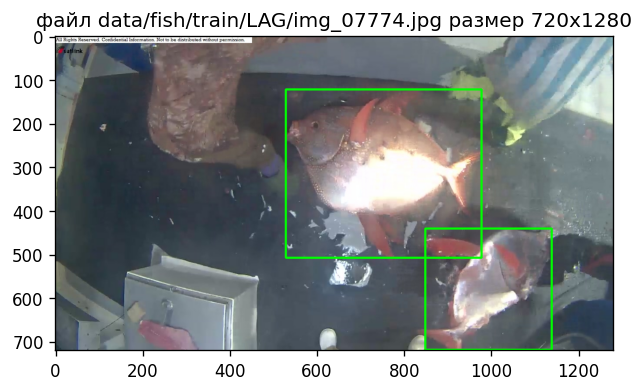

In [14]:
from matplotlib import pyplot as plt


annotation = boxes['lag'][0]
img = draw_boxes(annotation)

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(img)
plt.title('файл {} размер {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

### Распределение размеров разметки

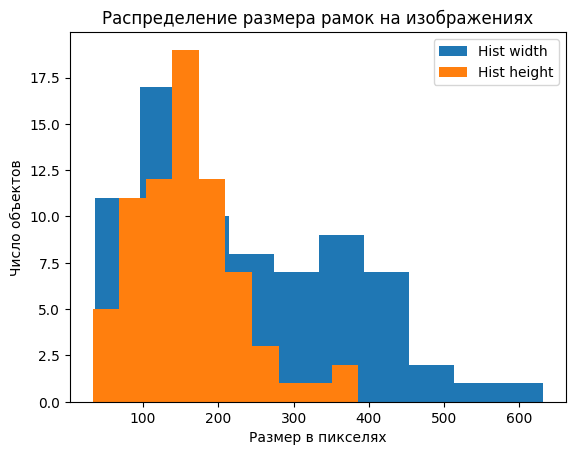

In [15]:
annotations = sum([box['annotations']
                   for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights)
plt.title('Распределение размера рамок на изображениях')
plt.legend(['Hist width','Hist height'], loc='upper right')
plt.xlabel('Размер в пикселях')
plt.ylabel('Число объектов')
plt.show()

# Экстрактор признаков

In [16]:
from tensorflow.keras.applications import vgg16

IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = vgg16.VGG16(weights='imagenet',
                       include_top=False,
                       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# дообучаем последние 5 слоев
for layer in features.layers[:-5]:
    layer.trainable = False

feature_tensor = features.layers[-1].output
print(feature_tensor.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
(None, 23, 37, 512)


# Сетка якорей (anchor grid)

In [17]:
FEATURE_SHAPE = (feature_tensor.shape[1],
                 feature_tensor.shape[2])

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = 150.
ANCHOR_HEIGHT = 150.

# сетка якорей, размер определяется соотношением
# размера входного изображения и размером тензора признаков
ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [18]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):

    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale

    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale

    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2

    dx = (min(rect_x2, anch_x2) - max(rect_x1, anch_x1))
    dy = (min(rect_y2, anch_y2) - max(rect_y1, anch_y1))

    intersection = dx * dy if (dx > 0 and dy > 0) else 0.

    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection

    return intersection / union

def encode_anchors(annotation, img_shape, iou_thr=0.5):
    encoded = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)
        if scores[0][0] < iou_thr:
            scores = [scores[0]]  # default anchor
        else:
            scores = [e for e in scores if e[0] > iou_thr]

        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded[row, col] = [1., dx, dy, dw, dh]

    return encoded

def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

def decode_prediction(prediction, conf_thr=0.1):
    rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            logit, dx, dy, dw, dh = prediction[row, col]
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                   'y': anchor_y - dy * ANCHOR_HEIGHT,
                                   'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                   'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                   'conf': conf})
    return rectangles

def non_max_suppression(rectangles, max_output_size, iou_threshold=0.5):
    if not rectangles:
        return rectangles

    boxes = [[r['y'],
              r['x'],
              r['y'] + r['height'],
              r['x'] + r['width']] for r in rectangles]
    scores = [r['conf'] for r in rectangles]
    indices = tf.image.non_max_suppression(np.array(boxes),
                                           np.array(scores),
                                           max_output_size,
                                           iou_threshold)

    return [rectangles[i] for i in indices]

### Валидация энкодинга/декодинга якорей

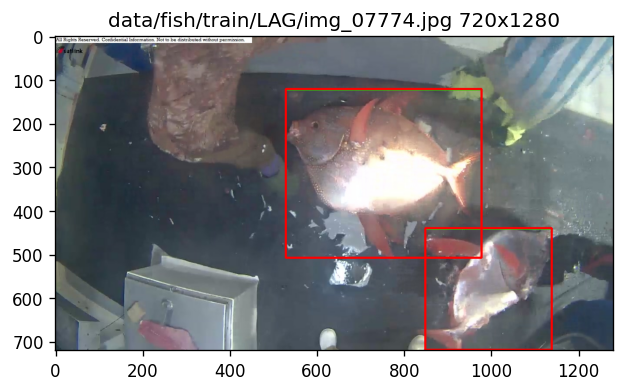

In [19]:
annotation = boxes['lag'][0]

encoded = encode_anchors(annotation,
                         img_shape=(IMG_HEIGHT, IMG_WIDTH),
                         iou_thr=0.5)

decoded = decode_prediction(encoded, conf_thr=0.7)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(annotation, decoded))
plt.title('{} {}x{}'.format(
    annotation['filename'], img.shape[0], img.shape[1]));

## Функция потерь

In [20]:
K = tf.keras.backend

def classification_loss(y_true, y_pred):
    cce = tf.keras.losses.CategoricalCrossentropy()
    return cce(y_true, y_pred)

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0],
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true)[0]

    y_true = K.reshape(y_true, (batch_size, -1, 5))
    y_pred = K.reshape(y_pred, (batch_size, -1, 5))

    # classification_loss
    class_loss = classification_loss(y_true, y_pred)

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)

    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)

    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)

    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])

    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)

    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)

    return total_conf_loss + 0.5 * loc_loss + class_loss

## Загрузка данных

In [21]:
from random import shuffle
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical

# Создаем LabelEncoder для преобразования строковых меток в числовые
label_encoder = LabelEncoder()
labels = list(boxes.keys())  # Получаем список всех уникальных классов
label_encoder.fit(labels)  # Обучаем LabelEncoder на всех классах


def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y = [], []
            for j in range(i*batch_size, (i+1)*batch_size):
                # Проверяем, что метка класса есть в списке labels
                if boxes[j]['class'] not in labels:
                    continue  # Пропускаем данные с неизвестными метками

                img_shape, img = load_img(boxes[j]['filename'])

                # Преобразуем строковую метку класса в числовую
                class_label = boxes[j]['class']
                class_numeric = label_encoder.transform([class_label])[0]  # Преобразуем в число

                # One-hot encoding для классов
                class_one_hot = to_categorical(class_numeric, num_classes=len(labels))  # Количество классов

                # Добавляем данные в батч
                y.append([float(boxes[j]['class'] == label) for label in labels])
                #y.append(encode_anchors(boxes[j], img_shape))
                X.append(img)
            if len(X) > 0:  # Убедимся, что в батче есть данные
                yield np.array(X), [np.array(y), np.array(class_one_hot)]

## Добавляем выход детектора

In [22]:
output = tf.keras.layers.Flatten()(feature_tensor)
output = tf.keras.layers.Dense(256, activation='relu')(output)
output = tf.keras.layers.Dropout(0.4)(output)
output = tf.keras.layers.BatchNormalization()(output)
output = tf.keras.layers.Dense(8, activation='softmax')(output)

model = tf.keras.models.Model(inputs=features.inputs, outputs=output)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 750, 1200, 3)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 750, 1200, 64)       │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 750, 1200, 64)       │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 375, 600, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 375, 600, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 375, 600, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 187, 300, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 187, 300, 256)       │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 187, 300, 256)       │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 93, 150, 256)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 93, 150, 512)        │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 93, 150, 512)        │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 46, 75, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 46, 75, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 23, 37, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 435712)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     111,542,528 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 126,260,296 (481.64 MB)

 Trainable params: 118,624,520 (452.52 MB)

 Non-trainable params: 7,635,776 (29.13 MB)

## Обучение

In [23]:
adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
model.compile(optimizer=adam,
              loss=total_loss,
              metrics=[confidence_loss])

In [ ]:
batch_size = 5

gen = data_generator(boxes, batch_size=batch_size)
steps_per_epoch = sum(map(len, boxes.values())) // batch_size


checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'fishdetector.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq=10)

model.fit(gen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          callbacks=[checkpoint])

## Результат работы детектора

In [ ]:
# model.load_weights('data/fish/fishdetector_weights.hdf5')

In [ ]:
annotation = boxes['lag'][0]

_, sample_img = load_img(annotation['filename'])
pred = model.predict(np.array([sample_img,]))

decoded = decode_prediction(pred[0], conf_thr=0.2)
decoded = non_max_suppression(decoded,
                              max_output_size=5,
                              iou_threshold=0.1)

plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(annotation, decoded, (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('Предсказание модели {}x{}'.format(*img.shape));

## Визуализируем предсказание на тесте

In [ ]:
test_images = glob('data/fish/test_stg1/*.jpg')[:5]


plt.figure(figsize=(6, 4 * len(test_images)), dpi=120)

for i, filename in enumerate(test_images):
    _, sample_img = load_img(filename)
    pred = model.predict(np.array([sample_img,]))

    decoded = decode_prediction(pred[0], conf_thr=0.0)
    decoded = non_max_suppression(decoded,
                                  max_output_size=2,
                                  iou_threshold=0.1)

    plt.subplot(len(test_images), 1, i + 1)
    img = draw_boxes({'filename': filename}, decoded, (IMG_WIDTH, IMG_HEIGHT))
    plt.imshow(img)
    plt.title('Предсказание на тесте {}'.format(filename));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0